In [13]:
import pandas as pd
import xarray as xr
from matplotlib.cm import get_cmap
import matplotlib.pyplot as plt
import wrf as wrfpy
from optwrf import plots
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import numpy as np

In [2]:
# Open data from the full loop that I ran previously 
fx = xr.open_dataarray('../data/quantiles.nc')

In [3]:
wrfds = xr.open_dataset('/share/mzhang/jas983/wrf_data/met4ene/wrfout/ARW/offshore_wind/no_wfp/2020-02-04_28mp4lw4sw2lsm5pbl1cu/ow_wrfout_d03_2020-02-04-2020-02-12')

# Get the start_date and create the date string
datestr = str(wrfds.Time.dt.strftime('%Y-%m-%d %H:%M')[0].values)

# To start, we need to get the WRF map projection information (a Lambert Conformal grid),
# and find the domain boundaries in this projection.
# NOTE: this task MUST occurr before we regrid the WRF variables or the coordinates change and become incompatible.
wrf_cartopy_proj = plots.get_wrf_proj(wrfds, 'temp')
proj_bounds = plots.get_domain_boundary(wrfds, wrf_cartopy_proj)

Variables {'lat': 'XLAT', 'lon': 'XLONG'} cannot be renamed, those on the left are not in this dataset.


/home/jas983/anaconda3/envs/enspp/lib/python3.8/site-packages/xarray/conventions.py:512: SerializationWarning: variable 'pressure' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


In [42]:
def quantile_cn(fx, p, axis, proj_bounds, t_idx=0, add_cbar=True, plot_buoy=False):
    """
    Contour map of a specified quantile.
    """
    # Format date string and plot variable 
    datestr = (pd.Timestamp(fx.Start_time.values[0]) + pd.Timedelta(hours=t_idx)).strftime('%Y-%m-%d %H:%M')
    plot_var = fx.sel(Step_index=t_idx, Percentile=p).reset_coords('Step_index', drop=True).squeeze()

    # Plot the 10th percentile wind speed across the domain
    cn = axis.contourf(wrfpy.to_np(fx.XLONG), wrfpy.to_np(fx.XLAT), wrfpy.to_np(plot_var),
                    np.linspace(0, 16, 121), transform=ccrs.PlateCarree(), cmap='viridis')

    if plot_buoy:             
        # Plot the buoy locations
        axis.plot(-72.716692, 39.969278, transform=ccrs.PlateCarree(), markersize=8, marker='X', color='grey')
        axis.plot(-73.428892, 39.546772, transform=ccrs.PlateCarree(), markersize=8, marker='X', color='grey')

    # Format the projected bounds so they can be used in the xlim and ylim attributes
    proj_xbounds = [proj_bounds[0, 0], proj_bounds[1, 0]]
    proj_ybounds = [proj_bounds[0, 1], proj_bounds[1, 1]]

    # Set the x and y limits
    axis.set_xlim(proj_xbounds)
    axis.set_ylim(proj_ybounds)

    # Download and add the states, coastlines, and lakes
    shapename = 'admin_1_states_provinces_lakes'
    states_shp = shpreader.natural_earth(resolution='10m',
                                    category='cultural', 
                                    name=shapename)
    # Add features to the maps
    axis.add_geometries(
            shpreader.Reader(states_shp).geometries(),
            ccrs.PlateCarree(),
            facecolor='none',
            linewidth=.5, 
            edgecolor="black"
            )
    # Note that the coastline is actually redundant in some cases,
    # so will cause cartopy to issue a warning
    axis.add_feature(cfeature.COASTLINE)

    if add_cbar:
        # Add color bars
        cbar_ticks=(0, 4, 8, 12, 16)
        cbar_tick_labels=[0, 4, 8, 12, 16]
        cbar = plt.colorbar(cn,
                        ax=axis,
                        ticks=cbar_ticks,
                        shrink=0.82,
                        pad=0.04,
                        label='Wind Speed ($m/s$)'
                        )
        cbar.ax.set_yticklabels(cbar_tick_labels)  # vertically oriented colorbar

    # Add the axis title
    tex = '$^{th}$'
    axis.set_title(f'{datestr}  {p}{tex} Percentile', fontsize=12)
    return cn

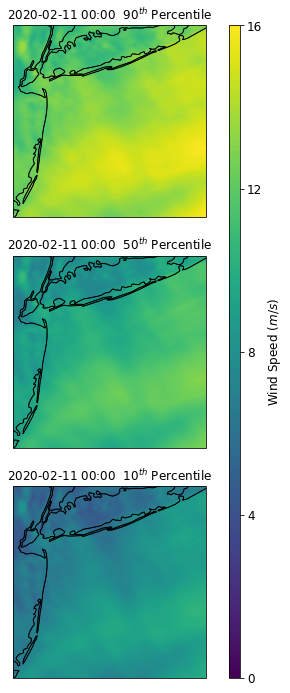

In [63]:
# Set the figure size
fig = plt.figure(figsize=(4, 12))
# Set the GeoAxes to the projection used by WRF
ax_wrf1 = fig.add_subplot(3, 1, 1, projection=wrf_cartopy_proj)
ax_wrf2 = fig.add_subplot(3, 1, 2, projection=wrf_cartopy_proj)
ax_wrf3 = fig.add_subplot(3, 1, 3, projection=wrf_cartopy_proj)

quantile_cn(fx, 90, ax_wrf1, proj_bounds, t_idx=0, add_cbar=False, plot_buoy=False)
quantile_cn(fx, 50, ax_wrf2, proj_bounds, t_idx=0, add_cbar=False, plot_buoy=False)
cn = quantile_cn(fx, 10, ax_wrf3, proj_bounds, t_idx=0, add_cbar=False, plot_buoy=False)

# Add a color bar to the full plot
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.90, 0.125, 0.04, 0.755])  # [left, bottom, width, height]
cbar_ticks=(0, 4, 8, 12, 16)
cbar_tick_labels=[0, 4, 8, 12, 16]
cbar = fig.colorbar(cn, cax=cbar_ax, ticks=cbar_ticks)
cbar.ax.set_yticklabels(cbar_tick_labels, fontsize=12)
cbar.set_label(label='Wind Speed ($m/s$)', size=12)

plt.savefig(f'../data/plots/multiquantile_map_{datestr}.png', dpi=300, transparent=True, bbox_inches='tight')

plt.show()